# Chest x-ray data set (Pneumonia)

## Augmenting 700 images for normal class from training set

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import os 
import random 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


In [2]:
#Note: I split NORMAL Images into another directory so I could use imagedatagenerator.flow_from_directory (needs two classes)
#copied and pasted ~ half of images into another folder. 
#Augmented images will be copied into NORMAL folder which is before the split I did

train_path = 'C:\\Users\\jamie\\jupyter notebooks\\Chest_Xrays2\\chest_xray\\train\\Norm'

gen = ImageDataGenerator(rotation_range = 10, width_shift_range = 0.1,
                        height_shift_range=0.1, shear_range=0.15, zoom_range = 0.1,
                        channel_shift_range=10., horizontal_flip = True)

In [5]:
#flow_from_directory batch size default is 32. batch size will say how many samples to augment. I will agument 700
# I did 700 batches and 1 iterations for the images so 700*1 = 700. this makes sure I get 1 augmented image for the first
# 700 samples

aug_iter = gen.flow_from_directory(directory=train_path, target_size = (224,224), save_to_dir = 'C:\\Users\\jamie\\jupyter notebooks\\Chest_Xrays2\\chest_xray\\train\\Norm',save_prefix ='aug-image-', save_format = 'JPEG', batch_size = 700, color_mode = 'grayscale')

aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range (1)]


Found 1341 images belonging to 2 classes.


## Resampling 3000 images from Pneumonia in the training set

In [6]:
# Creating a new directory for the Pneumonia class to resample 3000 images from ~ 3875. undersampling so the class imbalance
# is reduced between pneumonia and normal images
# all pneumonia images have person in the filename so glob.glob will patern match it
#shutil takes two arguments, source and destination 

import os
import glob
import random
import shutil

os.chdir("C:\\Users\\jamie\\jupyter notebooks\\Chest_Xrays2\\chest_xray\\train\\PNEUMONIA")
if os.path.isdir('train\\Pneumonia_new') is False:
    os.makedirs('train\\Pneumonia_new')
    
    for image in random.sample(glob.glob('person*'), 3000):
        shutil.move(image, 'train\\Pneumonia_new')

## Sampling images from training set and placing into validation set (Normal)

In [7]:
#Note. the files were divided with 3 different names. Norm, Image and augmented.

os.chdir('C:\\Users\\jamie\\jupyter notebooks\\Chest_Xrays2\\chest_xray\\train\\Norm')
if os.path.isdir('valid\\normal')is False: 
    os.makedirs('valid\\normal')
    
    for image in random.sample(glob.glob('Norm*'),150):
        shutil.move(image, 'valid\\normal')
    for image in random.sample(glob.glob('aug*'),150):
        shutil.move(image, 'valid\\normal')
    for image in random.sample(glob.glob('IM*'),200):
        shutil.move(image, 'valid\\normal')

## Sampling images from training set and placing into validation set (pneumonia)

In [8]:
os.chdir('C:\\Users\\jamie\\jupyter notebooks\\Chest_Xrays2\\chest_xray\\train\\Pneumonia')
if os.path.isdir('valid\\pneumonia')is False: 
    os.makedirs('valid\\pneumonia')
    
    for image in random.sample(glob.glob('Person*'),750):
        shutil.move(image, 'valid\\pneumonia')
    

# Preparing data 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools 
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
%matplotlib inline

In [2]:
#Creating a variable path for train, valid and test sets 

train_path = 'C:\\Users\\jamie\\jupyter notebooks\\Chest_Xrays2\\chest_xray\\train'

valid_path = 'C:\\Users\\jamie\\jupyter notebooks\\Chest_Xrays2\\chest_xray\\valid'

test_path = 'C:\\Users\\jamie\\jupyter notebooks\\Chest_Xrays2\\chest_xray\\test'


In [3]:
#set test_batches unshuffle to false since we want to access unshuffled labels later

#I used color_mode param here.

#Note: I was having a hard time intially getting things to work. vgg16.preprocess_input was trained with RGB images
#with 3 channels. I have gray images so the preprocessing function was messing it up since it wasn't designed for 1 input

train_batches = ImageDataGenerator()\
.flow_from_directory(directory = train_path, target_size = (224,224), classes = ['normal', 'pneumonia'], batch_size = 10, color_mode = 'grayscale')

valid_batches = ImageDataGenerator()\
.flow_from_directory(directory = valid_path, target_size = (224,224), classes = ['normal', 'pneumonia'], batch_size = 10, color_mode = 'grayscale')

test_batches = ImageDataGenerator()\
.flow_from_directory(directory = test_path, target_size = (224,224), classes = ['normal', 'pneumonia'], batch_size = 10, shuffle = False, color_mode = 'grayscale')



Found 3791 images belonging to 2 classes.
Found 1250 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Building and training a CNN

In [6]:
#input shape 1 on last dimension due to gray images. RGB have 3 channels

model = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,1)),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Flatten(),
    Dense(units = 2, activation = 'softmax'),
    
])

In [7]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 401410    
Total params: 420,226
Trainable params: 420,226
Non-trainable params: 0
________________________________________________

In [19]:
model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [9]:
#we don't specify y in the model.fit because train_batches is stored as a generator and contains
#corresponding labels.

model.fit(x= train_batches, validation_data = valid_batches, epochs = 10, verbose = 2)

Epoch 1/10
380/380 - 328s - loss: 1.5690 - accuracy: 0.8826 - val_loss: 1.3217 - val_accuracy: 0.8008
Epoch 2/10
380/380 - 171s - loss: 0.1544 - accuracy: 0.9657 - val_loss: 0.2542 - val_accuracy: 0.9560
Epoch 3/10
380/380 - 171s - loss: 0.0463 - accuracy: 0.9839 - val_loss: 0.2082 - val_accuracy: 0.9584
Epoch 4/10
380/380 - 181s - loss: 0.0214 - accuracy: 0.9929 - val_loss: 0.1888 - val_accuracy: 0.9576
Epoch 5/10
380/380 - 184s - loss: 0.0076 - accuracy: 0.9966 - val_loss: 0.1961 - val_accuracy: 0.9640
Epoch 6/10
380/380 - 184s - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.2073 - val_accuracy: 0.9672
Epoch 7/10
380/380 - 183s - loss: 4.9647e-04 - accuracy: 1.0000 - val_loss: 0.2017 - val_accuracy: 0.9672
Epoch 8/10
380/380 - 189s - loss: 1.6033e-04 - accuracy: 1.0000 - val_loss: 0.2088 - val_accuracy: 0.9664
Epoch 9/10
380/380 - 183s - loss: 1.1352e-04 - accuracy: 1.0000 - val_loss: 0.2126 - val_accuracy: 0.9664
Epoch 10/10
380/380 - 182s - loss: 8.0727e-05 - accuracy: 1.0000 - val

# Predicting 

In [10]:
predictions = model.predict(x = test_batches, verbose = 0)

In [11]:
np.round(predictions) 
#first sample here has higher probability of being normal (healthy) whereas second sample has 
# higher probability of having pneumonia

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [12]:
#creating confusion matrix

cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))

# from scikit-learn (copied straight)

def plot_confusion_matrix(cm,classes, normalize=False, title = 'Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize = True'
   
   """
    plt.imshow(cm, interpolation='nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]> thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[102 132]
 [ 11 379]]


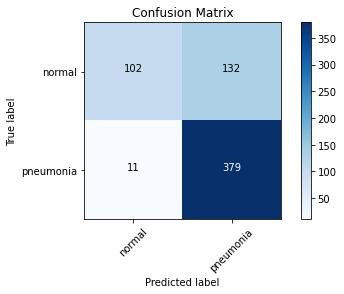

In [13]:
test_batches.class_indices

#since we know normal = 0 and pneumonia = 1, we will create confusion matrix labels

cm_labels = ['normal', 'pneumonia']
plot_confusion_matrix(cm = cm, classes = cm_labels, title = 'Confusion Matrix')

#accuracy on test set was 77% 

# Second CNN model

In [16]:
model2 = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,1)),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Conv2D(filters = 96, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), strides =2),
    Flatten(),
    Dense(units = 2, activation = 'softmax'),
    
])

In [22]:
model2.compile(optimizer = Adam(lr = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 96)        55392     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 96)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 75264)            

In [21]:
model2.fit(x= train_batches, validation_data = valid_batches, epochs = 15, verbose = 2)

Epoch 1/15
380/380 - 225s - loss: 4.5734 - accuracy: 0.8354 - val_loss: 0.2159 - val_accuracy: 0.9136
Epoch 2/15
380/380 - 228s - loss: 0.1642 - accuracy: 0.9377 - val_loss: 0.1941 - val_accuracy: 0.9272
Epoch 3/15
380/380 - 227s - loss: 0.2415 - accuracy: 0.9040 - val_loss: 0.2896 - val_accuracy: 0.8768
Epoch 4/15
380/380 - 239s - loss: 0.2082 - accuracy: 0.9209 - val_loss: 0.2797 - val_accuracy: 0.8968
Epoch 5/15
380/380 - 234s - loss: 0.1759 - accuracy: 0.9367 - val_loss: 0.2831 - val_accuracy: 0.9040
Epoch 6/15
380/380 - 228s - loss: 0.1359 - accuracy: 0.9459 - val_loss: 0.3684 - val_accuracy: 0.8776
Epoch 7/15
380/380 - 225s - loss: 0.1097 - accuracy: 0.9612 - val_loss: 0.2426 - val_accuracy: 0.9424
Epoch 8/15
380/380 - 229s - loss: 0.1005 - accuracy: 0.9620 - val_loss: 0.2381 - val_accuracy: 0.9416
Epoch 9/15
380/380 - 240s - loss: 0.0779 - accuracy: 0.9707 - val_loss: 0.4032 - val_accuracy: 0.9056
Epoch 10/15
380/380 - 242s - loss: 0.0960 - accuracy: 0.9707 - val_loss: 0.4810 - 

# Predicting model 2

Confusion matrix, without normalization
[[112 122]
 [ 30 360]]


0.7564102564102564

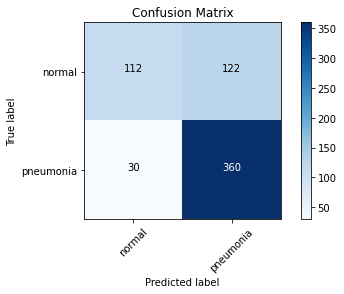

In [24]:
predictions2 = model2.predict(x = test_batches, verbose = 0)
cm2 = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions2, axis = -1))
cm_labels = ['normal', 'pneumonia']
plot_confusion_matrix(cm = cm2, classes = cm_labels, title = 'Confusion Matrix')

(360+112)/(360+112+122+30)

# Third CNN model

In [25]:
model3 = Sequential([
    Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu', padding = 'same', input_shape = (224,224,1)),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), strides = 2),
    Conv2D(filters = 96, kernel_size = (3,3), activation = 'relu', padding = 'same'),
    MaxPool2D(pool_size = (2,2), strides =2),
    Flatten(),
    Dense(units = 2, activation = 'softmax'),
    
])

In [26]:
model3.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 96)        55392     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 28, 28, 96)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 75264)            

In [27]:
model3.fit(x= train_batches, validation_data = valid_batches, epochs = 20, verbose = 2)

Epoch 1/20
380/380 - 214s - loss: 0.8727 - accuracy: 0.8773 - val_loss: 0.1797 - val_accuracy: 0.9360
Epoch 2/20
380/380 - 219s - loss: 0.1222 - accuracy: 0.9559 - val_loss: 0.1610 - val_accuracy: 0.9544
Epoch 3/20
380/380 - 225s - loss: 0.0515 - accuracy: 0.9802 - val_loss: 0.1976 - val_accuracy: 0.9440
Epoch 4/20
380/380 - 227s - loss: 0.0234 - accuracy: 0.9902 - val_loss: 0.1329 - val_accuracy: 0.9624
Epoch 5/20
380/380 - 229s - loss: 0.0174 - accuracy: 0.9942 - val_loss: 0.1291 - val_accuracy: 0.9616
Epoch 6/20
380/380 - 231s - loss: 0.0097 - accuracy: 0.9982 - val_loss: 0.1416 - val_accuracy: 0.9648
Epoch 7/20
380/380 - 229s - loss: 0.0182 - accuracy: 0.9931 - val_loss: 0.1932 - val_accuracy: 0.9512
Epoch 8/20
380/380 - 230s - loss: 0.0545 - accuracy: 0.9778 - val_loss: 0.2019 - val_accuracy: 0.9648
Epoch 9/20
380/380 - 230s - loss: 0.0174 - accuracy: 0.9929 - val_loss: 0.1581 - val_accuracy: 0.9616
Epoch 10/20
380/380 - 231s - loss: 0.0043 - accuracy: 0.9995 - val_loss: 0.2142 - 

# Predicting model 3

Confusion matrix, without normalization
[[ 92 142]
 [  7 383]]


0.7612179487179487

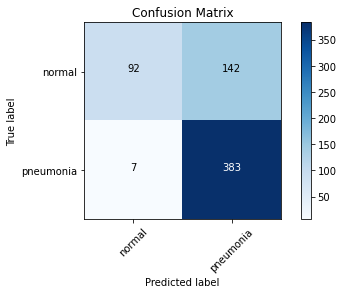

In [29]:
predictions3 = model3.predict(x = test_batches, verbose = 0)
cm3 = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions3, axis = -1))
cm_labels = ['normal', 'pneumonia']
plot_confusion_matrix(cm = cm3, classes = cm_labels, title = 'Confusion Matrix')

(383+92)/(383+92+142+7) #76% accurate